Import libraries

In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt

*Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


Useful functions

In [4]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked

Sample strategies

In [5]:
def optimal_normal(state: Nim) -> Nimply:
    """Optimal strategy for the 'normal play' variant of the game"""

    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")

    # rows with a number of elements greater then or equal to 2
    rows_gte_two = [(r, c) for r, c in enumerate(state.rows) if c >= 2]

    # check if the number of rows with at least two objects is exactly equal to one
    if len(rows_gte_two) == 1:
        # leave an even number of rows of size 1
        num_one_rows = np.sum([1 for row in state.rows if row == 1])

        # if the number of rows of size 1 is even yet: take all the row with a number of elements greater then or equal to 2
        if num_one_rows % 2 == 0:
            ply = Nimply(rows_gte_two[0][0], rows_gte_two[0][1])
        # else: take n-1 elements from the row with a number of elements greater then or equal to 2
        else:
            ply = Nimply(rows_gte_two[0][0], rows_gte_two[0][1] - 1)
    # otherwise leave the nim-sum to 0, if possible, i.e., if nim-sum is not zero yet
    else:
        spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]

        # if not possible, take a random move
        if not spicy_moves:
            spicy_moves = list(analysis["possible_moves"].keys())
        ply = random.choice(spicy_moves)
        
    return ply

def optimal_misere(state: Nim) -> Nimply:
    """Optimal strategy for the 'misère game' variant of the game"""

    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")

    # rows with a number of elements greater then or equal to 2
    rows_gte_two = [(r, c) for r, c in enumerate(state.rows) if c >= 2]

    # check if the number of rows with at least two objects is exactly equal to one
    if len(rows_gte_two) == 1:
        # leave an odd number of rows of size 1
        num_one_rows = np.sum([1 for row in state.rows if row == 1])

        # if the number of rows of size 1 is odd yet: take all the row with a number of elements greater then or equal to 2
        if num_one_rows % 2 == 1:
            ply = Nimply(rows_gte_two[0][0], rows_gte_two[0][1])
        # else: take n-1 elements from the row with a number of elements greater then or equal to 2
        else:
            ply = Nimply(rows_gte_two[0][0], rows_gte_two[0][1] - 1)
    # otherwise leave the nim-sum to 0, if possible, i.e., if nim-sum is not zero yet
    else:
        # otherwise leave the nim-sum to 0, if possible, i.e., nim-sum is not zero yet
        spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]

        # if not possible, take a random move
        if not spicy_moves:
            spicy_moves = list(analysis["possible_moves"].keys())
            
        ply = random.choice(spicy_moves)
        
    return ply

def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

def luca(state: Nim) -> Nimply:
    """Pick always the min possible number of the highest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*min(possible_moves, key=lambda m: (m[0], m[1])))

Nim match class

In [6]:
logging.getLogger().setLevel(logging.INFO)

class Nim_Match:
    def __init__(self, game_dimesion, player1, player2, version='normal') -> None:
        versions = ['normal', 'misere']
        if version not in versions:
            raise ValueError("Invalid game version. Expected one of: %s" % versions)
        
        self.nim = Nim(game_dimesion)
        self.strategies = (player1, player2)
        self.version = version

    def play(self, verbose=False):
        if verbose:
            logging.info(f"init : {self.nim}")
        player = 0
        while self.nim:
            ply = self.strategies[player](self.nim)

            if verbose:
                logging.info(f"ply: player {self.strategies[player].__name__} plays {ply}")
            self.nim.nimming(ply)
            if verbose:
                logging.info(f"status: {self.nim}")
            player = 1 - player

        if verbose:
            if self.version == 'normal':
                logging.info(f"status: Player {self.strategies[1 - player].__name__} won!")
            elif self.version == 'misere':
                logging.info(f"status: Player {self.strategies[player].__name__} won!")
            else:
                raise ValueError('Game version not implemented yet')

        if self.version == 'normal':
            return 1 - player
        elif self.version == 'misere':
            return player
        else:
            raise ValueError('Game version not implemented yet')

Example of game

In [7]:
players = (optimal_misere, pure_random)
match = Nim_Match(5, players[0], players[1], 'misere')
print()
winner = match.play(verbose=True)
print("The winner is:", players[winner].__name__)

INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player optimal_misere plays Nimply(row=4, num_objects=9)
INFO:root:status: <1 3 5 7 0>
INFO:root:ply: player pure_random plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 0>
INFO:root:ply: player optimal_misere plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 3 5 6 0>
INFO:root:ply: player pure_random plays Nimply(row=3, num_objects=4)
INFO:root:status: <0 3 5 2 0>
INFO:root:ply: player optimal_misere plays Nimply(row=2, num_objects=4)
INFO:root:status: <0 3 1 2 0>
INFO:root:ply: player pure_random plays Nimply(row=1, num_objects=2)
INFO:root:status: <0 1 1 2 0>
INFO:root:ply: player optimal_misere plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 1 1 1 0>
INFO:root:ply: player pure_random plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 1 0 1 0>
INFO:root:ply: player optimal_misere plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 1 0 0 0>
INFO:root:ply: player pure_random plays Nimply(row=1, num_objects


The winner is: optimal_misere


## Fitness function
Computes how many wins a strategy choosen according to the roulette wheel obtains over a total number of matches. 

In [8]:
STRATEGIES = [optimal_normal, optimal_misere, pure_random, gabriele, luca]

def fitness(solution) -> float:
    """Evaluates how many wins the players obtains over a total number of matches. The player is choosen according to the roulette wheel strategy."""
    N_OPPONENTS = 50
    WIN_COUNTER = 0

    opponents = [gabriele] * 20 + [pure_random] * 20 + [optimal_misere] * 10
    turn = 0

    for i in range(N_OPPONENTS):
        # choose the strategy according to the roulette wheel
        my_strategy = random.choices(STRATEGIES, weights=solution, k=1)

        players = (my_strategy[0], opponents[i])
        match = Nim_Match(5, players[turn], players[1-turn], 'misere')
        winner = match.play()

        if turn == 0:
            WIN_COUNTER += 1 - winner
        else:
            WIN_COUNTER += winner
            
        turn = 1 - turn

    return WIN_COUNTER / N_OPPONENTS

## (1+λ) - Evolution Strategy


In [9]:
λ = 20
σ = 0.05
MAX_GENERATIONS = 50

solution = np.random.random(len(STRATEGIES))
history = list()
best_so_far = np.copy(solution)
best_fitness = .0

for n in tqdm(range(MAX_GENERATIONS // λ)):

    # mutation
    offsprings = (np.random.normal(loc=0, scale=σ, size=(λ, len(STRATEGIES))) + solution)

    # make all the weights positive (due to roulette wheel)
    for offspring in offsprings:
        offspring[offspring < 0] = 0
    
    # apply the fitness function to all the offsprings
    evals = [fitness(offspring) for offspring in offsprings]
    solution = offsprings[np.argmax(evals)]
    
    if np.max(evals) > best_fitness:
        best_so_far = np.copy(solution)
        best_fitness = np.max(evals)
        history.append((n, best_fitness))

strategies_names = [strategy.__name__ for strategy in STRATEGIES]
strategy_weights = dict(zip(strategies_names, best_so_far))

print("Strategy weights obtained:")
print(strategy_weights)

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.grid(alpha=0.4)
plt.title("Win ratio over generations")
plt.xlabel("Generation")
plt.ylabel("Wins / Total number of matches")
plt.plot(history[:, 0], history[:, 1], marker=".")

  0%|          | 0/250 [00:00<?, ?it/s]

  1%|          | 3/250 [00:09<12:30,  3.04s/it]


KeyboardInterrupt: 

## Adaptive 1+λ-ES

100%|██████████| 250/250 [12:40<00:00,  3.04s/it]

Best weights of the strategies: [0.00989962 0.89281007 0.13879125 0.01503617 0.13708597]


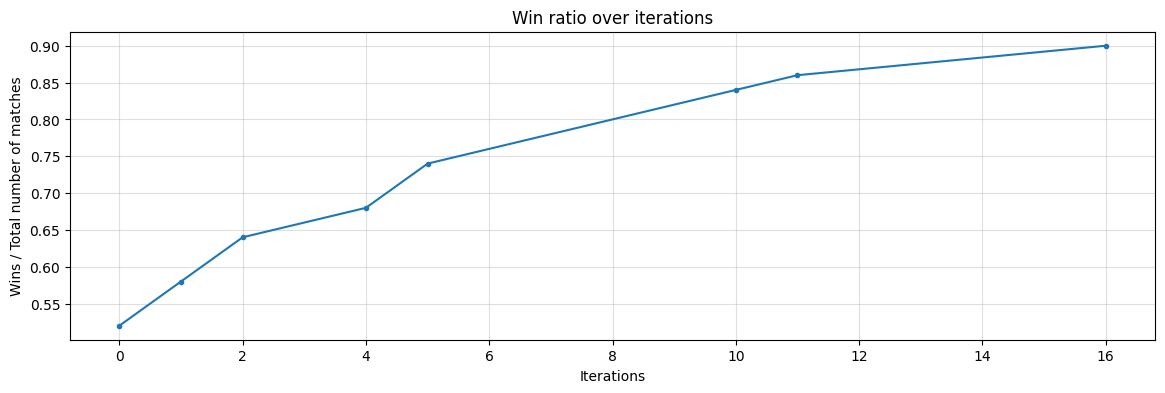

In [ ]:
λ = 20
σ = 0.05
MAX_GENERATIONS = 5000

solution = np.random.random(len(STRATEGIES))
history = list()
best_so_far = np.copy(solution)
best_fitness = .0
stats = [0, 0]

for n in tqdm(range(MAX_GENERATIONS // λ)):
    offsprings = (np.random.normal(loc=0, scale=σ, size=(λ, len(STRATEGIES))) + solution)
    
    # make all the weights positive
    for offspring in offsprings:
        offspring[offspring < 0] = 0

    evals = []
    for offspring in offsprings:
        evals.append(fitness(offspring))
    evals = np.array(evals)
    stats[0] += λ
    stats[1] += sum(evals > best_fitness)
    solution = offsprings[np.argmax(evals)]
    if np.max(evals) > best_fitness:
        best_so_far = np.copy(solution)
        best_fitness = np.max(evals)
        history.append((n, best_fitness))

    if (n + 1) % 20 == 0:
        if stats[0] / stats[1] < 1 / 5:
            σ /= 1.1
        elif stats[0] / stats[1] > 1 / 5:
            σ *= 1.1
        steps = [0, 0]

strategies_names = [strategy.__name__ for strategy in STRATEGIES]
strategy_weights = dict(zip(strategies_names, best_so_far))

print("Strategy weights obtained:")
print(strategy_weights)

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.grid(alpha=0.4)
plt.title("Win ratio over generations")
plt.xlabel("Generation")
plt.ylabel("Wins / Total number of matches")
plt.plot(history[:, 0], history[:, 1]*100, marker=".")

## 1,λ-ES

100%|██████████| 100/100 [08:21<00:00,  5.01s/it]

Best weights of the strategies: [0.         1.30222278 0.01542159 0.01443232 0.08389578]


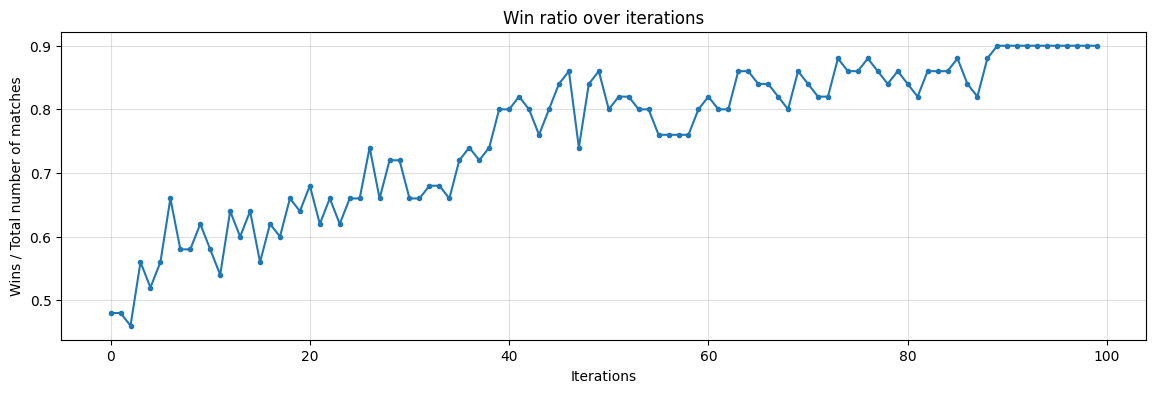

In [ ]:
λ = 50
σ = 0.05
MAX_GENERATIONS = 5000

solution = np.random.random(len(STRATEGIES))
history = list()
best_so_far = np.copy(solution)
best_fitness = .0

for n in tqdm(range(MAX_GENERATIONS // λ)):
    offsprings = (np.random.normal(loc=0, scale=σ, size=(λ, len(STRATEGIES))) + solution)
    
    # make all the weights positive
    for offspring in offsprings:
        offspring[offspring < 0] = 0
        
    evals = []
    for offspring in offsprings:
        evals.append(fitness(offspring))
    solution = offsprings[np.argmax(evals)]

    best_so_far = np.copy(solution)
    best_fitness = np.max(evals)
    history.append((n, best_fitness))

strategies_names = [strategy.__name__ for strategy in STRATEGIES]
strategy_weights = dict(zip(strategies_names, best_so_far))

print("Strategy weights obtained:")
print(strategy_weights)

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.grid(alpha=0.4)
plt.title("Win ratio over generations")
plt.xlabel("Generation")
plt.ylabel("Wins / Total number of matches played")
plt.plot(history[:, 0], history[:, 1], marker=".")

In [ ]:
values = [1, 2, 3, 4, 5]
strategies_names = [strategy.__name__ for strategy in STRATEGIES]
a = dict(zip(strategies_names, values))
a



{'optimal_normal': 1,
 'optimal_misere': 2,
 'pure_random': 3,
 'gabriele': 4,
 'luca': 5}